# Getting the most solar power for your dollar
## Exploratory Data Analysis
### Zachary Brown

Now that the raw data has been wrangled into a useful dataframe it is time to explore the data and identify correlations and trends that may be important for modeling. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(os.getcwd())
os.chdir(r"..\data\interim")
print(os.getcwd())

C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\data\interim


In [3]:
data = pd.read_csv('wrangled_data.csv', index_col=0, low_memory=False)
data.shape

(208257, 57)

In [4]:
data.head()

,data_provider_1,system_id_1,installation_date,system_size_dc,total_installed_price,rebate_or_grant,customer_segment,expansion_system,multiple_phase_system,tracking,...,state_MA,state_MD,state_MN,state_NH,state_NM,state_NY,state_RI,state_TX,state_UT,state_WI
108019,Arizona Public Service,107903,2020-06-17,5.760,17488.26,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108020,Arizona Public Service,107904,2020-06-17,8.750,22631.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108142,Arizona Public Service,108026,2020-06-19,4.725,18972.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108175,Arizona Public Service,108059,2020-06-22,3.550,9900.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
108233,Arizona Public Service,108117,2020-06-23,5.850,20475.00,0.0,RES,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data.columns

Index(['data_provider_1', 'system_id_1', 'installation_date', 'system_size_dc',
       'total_installed_price', 'rebate_or_grant', 'customer_segment',
       'expansion_system', 'multiple_phase_system', 'tracking',
       'ground_mounted', 'zip_code', 'city', 'utility_service_territory',
       'third_party_owned', 'installer_name', 'self_installed', 'azimuth_1',
       'tilt_1', 'module_manufacturer_1', 'module_model_1',
       'module_quantity_1', 'additional_modules', 'technology_module_1',
       'bipv_module_1', 'bifacial_module_1', 'nameplate_capacity_module_1',
       'efficiency_module_1', 'inverter_manufacturer_1', 'inverter_model_1',
       'inverter_quantity_1', 'additional_inverters', 'micro_inverter_1',
       'solar_storage_hybrid_inverter_1', 'built_in_meter_inverter_1',
       'dc_optimizer', 'inverter_loading_ratio', 'date_of_battery_install',
       'year', 'month', 'price_per_kw', 'state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_DE', 'state_FL', 'state_M

In [6]:
def ecdf(column):
    n = len(column)

    # x-data for the ECDF: x
    x = np.sort(column)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [7]:
tx = data[data['state_TX'] == 1]
not_tx = data[data['state_TX'] == 0]

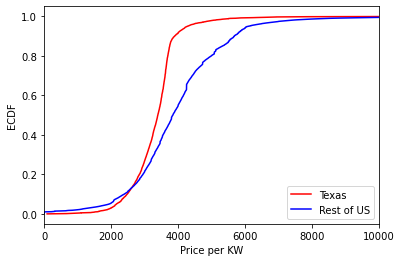

In [13]:
tx_x, tx_y = ecdf(tx['price_per_kw'])
us_x, us_y = ecdf(not_tx['price_per_kw'])

plt.plot(tx_x, tx_y, color='r')
plt.plot(us_x, us_y, color='b')
plt.xlim(0,10000)
plt.xlabel('Price per KW')
plt.ylabel('ECDF')
plt.legend(['Texas', 'Rest of US'], loc='lower right')
plt.show()

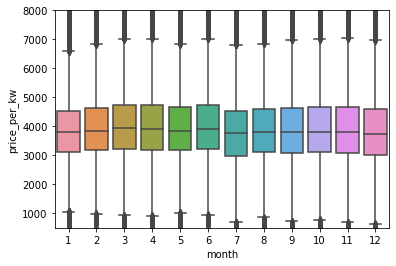

In [27]:
sns.boxplot(x='month', y='price_per_kw', data=data)
plt.ylim(500, 8000)
plt.show()